# **Final Project: Amazon Data Science Books Dataset**

**Team's Information:**
- Pham Anh Khoa - `22127198`
- Hoang Duy Hung - `22127139` 

## **1. Data Collection**
### **1.1 What subject is your data about?**
- Topic: This dataset contains information about books related to Data Science, Statistics, Machine Learning, Deep Learning and Python available on Amazon.
- Real-world context: This dataset represents the e-commerce market for educational resources in the data science domain, reflecting pricing strategies, reader's reviews, and publishing trends.

### **1.2 What is the source of your data?**
- Kaggle: https://www.kaggle.com/datasets/die9origephit/amazon-data-science-books/data.
- Author: Kaggle user `die9origephit`.
- No Publication/collection date.

### **1.3 Is this data licensed for your use?**
- License: CC0 1.0 Universal.
- Permissions: As a public dataset on Kaggle, it is generally permitted for educational and analytical purposes.

### **1.4 How was this data collected?**
- Method: The data was collected using `web scraping` from Amazon's website.
- Process: The author scraped over 1700 books, extracted key information (price, pages, reviews), deleted duplicates, and formatted columns. Rows with excessive missing values were removed, resulting in the final dataset.
- Time period of data collection:
    - Temporal Coverage Start Date: 09/19/2022
    - Temporal Coverage End Date: 09/19/2022

### **1.5 Why did you choose this dataset?**
- We are interested in understanding what factors drive the price and popularity of data science books. This dataset allows us to analyze the relationship between book length, ratings, and price.

## **2. Data Exploration**

### **Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

### **2.1 Dataset Overview**
#### **a. Basic Information**

In [3]:
# Load the dataset
df = pd.read_csv('data/final_book_dataset_kaggle2.csv')

rows, cols = df.shape
total_size = df.memory_usage(deep=True).sum() / (1024 * 1024) # Size in MB

# Basic Information
print(f"Total Rows: {rows}")
print(f"Total Columns: {cols}")
print(f"Overall Size: {total_size:.2f} MB")


Total Rows: 830
Total Columns: 19
Overall Size: 1.17 MB


**How many rows does your dataset have?**
- This dataset contains 830 rows. 

**How many columns does your dataset have?**
- This dataset contains 19 columns. 

**What does each row represent? (e.g., one customer, one transaction, one day)**
- Each row represents a unique book listing on Amazon related to Data Science, including its metadata (author, publisher) and customer engagement metrics (reviews, ratings). 

**What is the overall size of the dataset?**
- The overall size of the dataset is 1.17 MB.


#### **b. Data Integrity**

In [4]:
duplicates = df.duplicated().sum()
empty_rows = df.isnull().all(axis=1).sum()

print(f"Duplicated rows: {duplicates}")
print(f"Full empty rows: {empty_rows}")

Duplicated rows: 0
Full empty rows: 0


**Are there any duplicated rows? If yes, how many?**
- There are no duplicates in this dataset. 

**Should duplicates be kept or removed? (Justify your decision)**
- Since there are zero duplicates, no action is needed. If duplicates existed, they should be removed to prevent skewing statistical analysis (e.g., counting the same book's price twice). 

**Are all rows complete, or are some entirely empty?**
- No, not all rows are complete, some rows might contain missing information, but there are zero rows that are entirely empty.

#### **c. Column Inventory**

In [5]:
print("Column Inventory:")
for idx, col in enumerate(df.columns):
    print(f"{idx}: {col}")

Column Inventory:
0: title
1: author
2: price
3: price (including used books)
4: pages
5: avg_reviews
6: n_reviews
7: star5
8: star4
9: star3
10: star2
11: star1
12: dimensions
13: weight
14: language
15: publisher
16: ISBN_13
17: link
18: complete_link


**What is the meaning/definition of each column?** 
- `title:` The name of the book. (Relevant) 
- `author:` The writer(s) of the book. (Relevant) 
- `price:` The selling price of the book in USD. (Crucial for analysis) 
- `pages:` The length of the book. (Relevant for correlating with price) 
- `avg_reviews:` The average user rating (1-5 stars). (Crucial) 
- `n_reviews:` The total count of user reviews. (Crucial for popularity) 
- `star5 - star1:` Percentage breakdown of ratings for each star level. (Relevant) 
- `dimensions / weight:` Physical size and weight of the book. (Less relevant, but useful for physical vs digital analysis if applicable). 
- `language:` The language the book is written in. (Relevant for filtering). 
- `publisher:` The company that published the book. (Relevant). 
- `ISBN_13:` Unique book identifier. (Not relevant for analysis, used for ID). 
- `link / complete_link:` URL to the Amazon page. (Drop for analysis, keep for reference). 

**Which columns are relevant to potential analysis?**
- Highly relevant columns: `title, author, price, avg_reviews, n_reviews, star1-star5`
- Moderately relevant columns: `pages, language, publisher, dimensions / weight`
- Minimally relevant columns: `ISBN_13, link / complete_link`

**Are there any columns that should be dropped? Why?**
- `ISBN_13, link / complete_link` could be dropped because they do not provide any numerical or categorical insights, not useful for statistical, exploratory, or predictive analysis.

#### **d. Data Types**

In [6]:
print(df.dtypes)

title                            object
author                           object
price                           float64
price (including used books)     object
pages                            object
avg_reviews                     float64
n_reviews                        object
star5                            object
star4                            object
star3                            object
star2                            object
star1                            object
dimensions                       object
weight                           object
language                         object
publisher                        object
ISBN_13                          object
link                             object
complete_link                    object
dtype: object


**What is the current data type of each column?**
- Most columns are currently object (string), including numerical fields like `n_reviews`, `pages`, and `star5`. 

**Are there columns with inappropriate data types?**
- `n_reviews` is object (contains commas, e.g., "1,200").
- `star5...star1` are object (contain percent signs, e.g., "55%").
- `pages` is object (some entries might contain text). 

**Which columns need type conversion?**
- `n_reviews`, `pages`, `star columns`, and `weight` into float or int to perform any calculation.


### **2.2 Numerical Columns Analysis**

In [7]:
# Perform the necessary cleaning to enable analysis.
# Create a clean copy for analysis
df_clean = df.copy()

# Cleaning Functions
def clean_currency(x):
    if isinstance(x, str): return float(re.sub(r'[^\d.]', '', x)) # Remove $ and commas
    return x
def clean_reviews(x):
    if isinstance(x, str): return float(x.replace(',', '')) # Remove commas
    return x
def clean_percent(x):
    if isinstance(x, str): return float(x.replace('%', '')) # Remove percent sign
    return x
def extract_weight(x):
    if pd.isna(x): return None
    x_str = str(x).lower()
    match = re.search(r'(\d+(\.\d+)?)', x_str) # Find numeric part
    if match:
        value = float(match.group(1))
        if 'ounce' in x_str:
            return value / 16.0  # Convert ounces to pounds
        return value
    return None

# Apply cleaning
df_clean['n_reviews'] = pd.to_numeric(df_clean['n_reviews'].apply(clean_reviews), errors='coerce')
df_clean['pages'] = pd.to_numeric(df_clean['pages'], errors='coerce')
for col in ['star5', 'star4', 'star3', 'star2', 'star1']:
    df_clean[col] = df_clean[col].apply(clean_percent)
df_clean['weight_numeric'] = df_clean['weight'].apply(extract_weight)

#### **a. Distribution & Central Tendency**

In [8]:
# Select numeric columns
num_df = df_clean.select_dtypes(include=['int64', 'float64'])

# Summary Statistics
summary = num_df.describe()
print(summary)

             price        pages  avg_reviews     n_reviews       star5  \
count   722.000000   736.000000   702.000000    702.000000  702.000000   
mean     46.491537   391.078804     4.472080    325.792023   72.952991   
std      63.292394   237.871838     0.409608   1332.788216   14.721448   
min       0.990000     6.000000     1.000000      1.000000   20.000000   
25%      23.725000   240.000000     4.325000     13.000000   64.000000   
50%      39.490000   360.000000     4.500000     49.000000   73.000000   
75%      51.990000   493.750000     4.700000    171.750000   81.000000   
max    1318.740000  2962.000000     5.000000  26560.000000  100.000000   

            star4       star3       star2       star1  weight_numeric  
count  635.000000  554.000000  451.000000  328.000000      650.000000  
mean    17.118110    8.657040    4.290466    4.222561        1.678500  
std      8.764186    5.689818    3.350937    3.431618        1.867929  
min      1.000000    1.000000    1.000000    

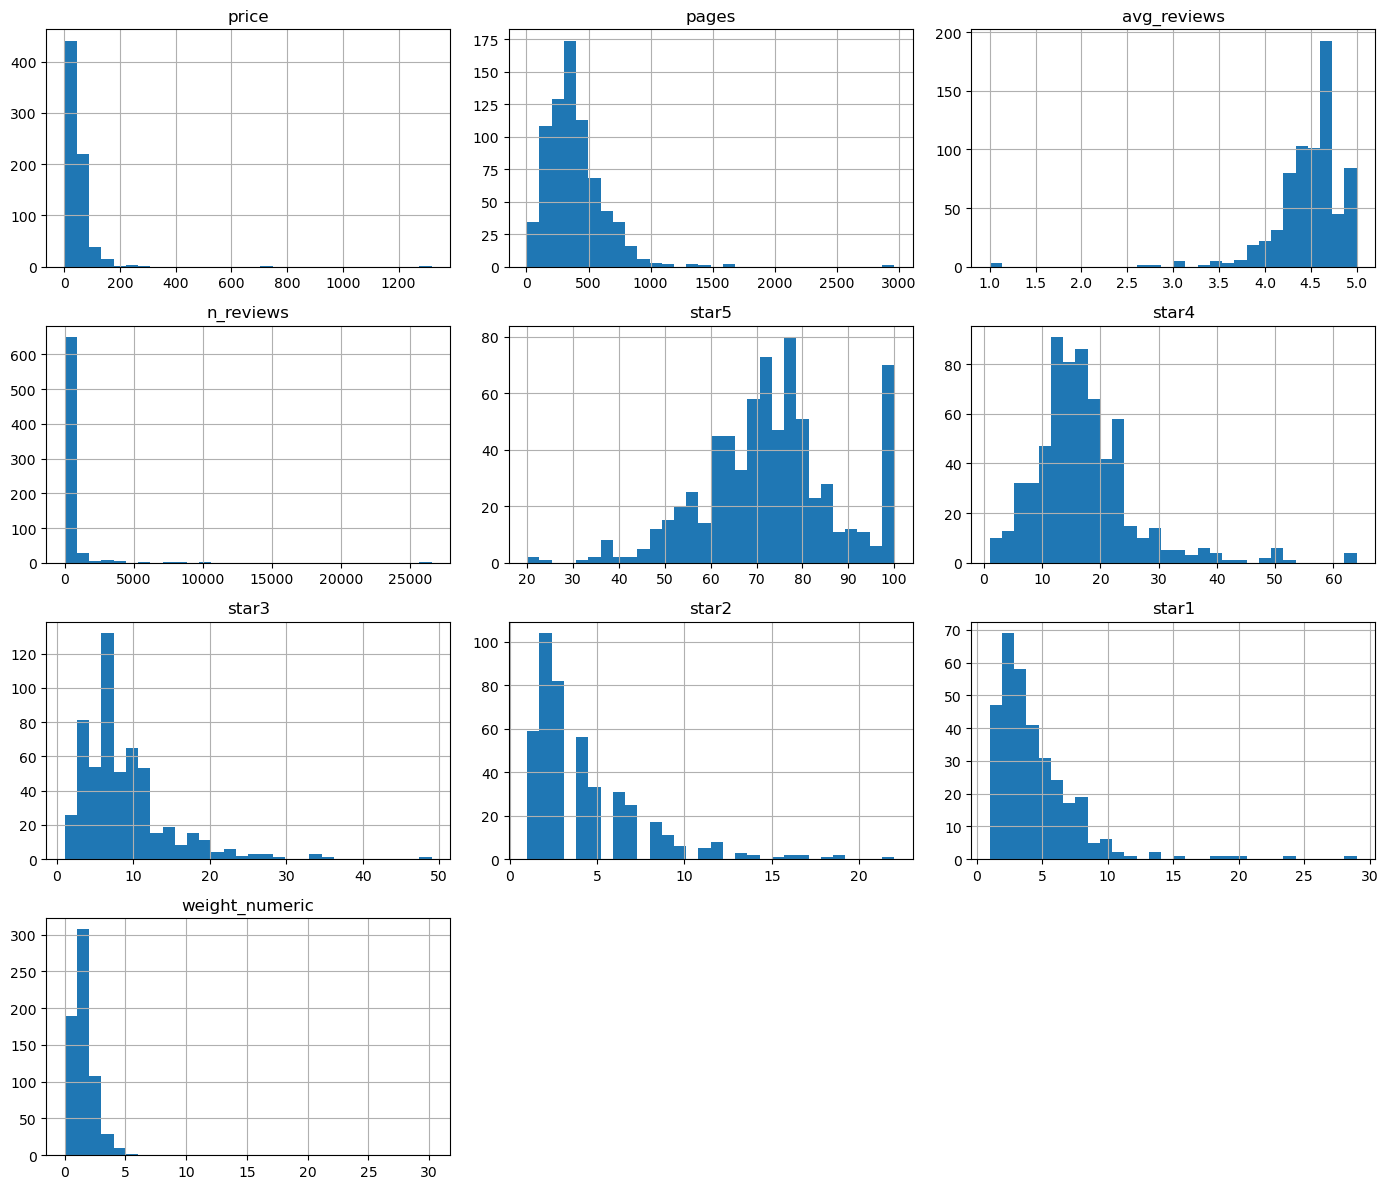

In [9]:
num_df.hist(figsize=(14, 12), bins=30)
plt.tight_layout()
plt.show()


**What is the distribution shape?**
- `price`: Highly Right-Skewed (Mean $46.49 > Median $39.49). The tail extends significantly to the right.
- `pages`: Right-Skewed (Mean 391 $\approx$ Median 360).
- `avg_reviews`: Highly Left-Skewed (Mean 4.47 < Median 4.50). The vast majority of books have high ratings (4+ stars).
- `n_reviews`: Extremely Right-Skewed (Mean 325 >> Median 49).
- `star5`: Approximately Normal but slightly Right-Skewed.
- `star4` to `star1`: Right-Skewed.
- `weight_numeric`: Right-Skewed (Skewness: 1.52). Most books are standard paperbacks (median ~2 lbs), but some are very heavy.  

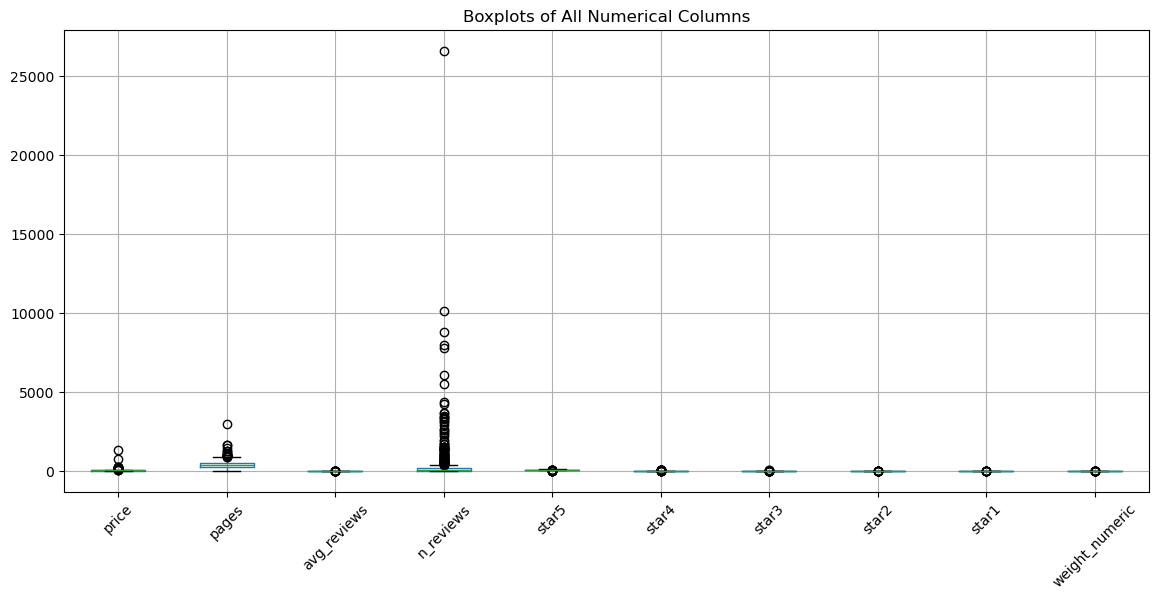

In [10]:
plt.figure(figsize=(14, 6))
num_df.boxplot()
plt.title("Boxplots of All Numerical Columns")
plt.xticks(rotation=45)
plt.show()

#### **b. Range & Outliers**

In [11]:
# MIN AND MAX
mins = num_df.min()
maxs = num_df.max()

# IQR
Q1 = num_df.quantile(0.25)
Q3 = num_df.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Boolean outlier mask for IQR
iqr_mask = (num_df.lt(lower_bound)) | (num_df.gt(upper_bound))
iqr_outlier_counts = iqr_mask.sum()

# Z-SCORE 
z_scores = (num_df - num_df.mean()) / num_df.std()
z_mask = z_scores.abs() > 3
z_outlier_counts = z_mask.sum()

# Combine results into a single table
results = pd.DataFrame({
    "min": mins,
    "max": maxs,
    "IQR_outliers": iqr_outlier_counts,
    "Z_outliers": z_outlier_counts
})

print(results)

                      min       max  IQR_outliers  Z_outliers
price            0.990000   1318.74            50           4
pages            6.000000   2962.00            19           7
avg_reviews      1.000000      5.00            25          10
n_reviews        1.000000  26560.00            88           8
star5           20.000000    100.00            14           3
star4            1.000000     64.00            33          13
star3            1.000000     49.00            24          10
star2            1.000000     22.00            14           9
star1            1.000000     29.00            11           6
weight_numeric   0.002188     30.20            24           5


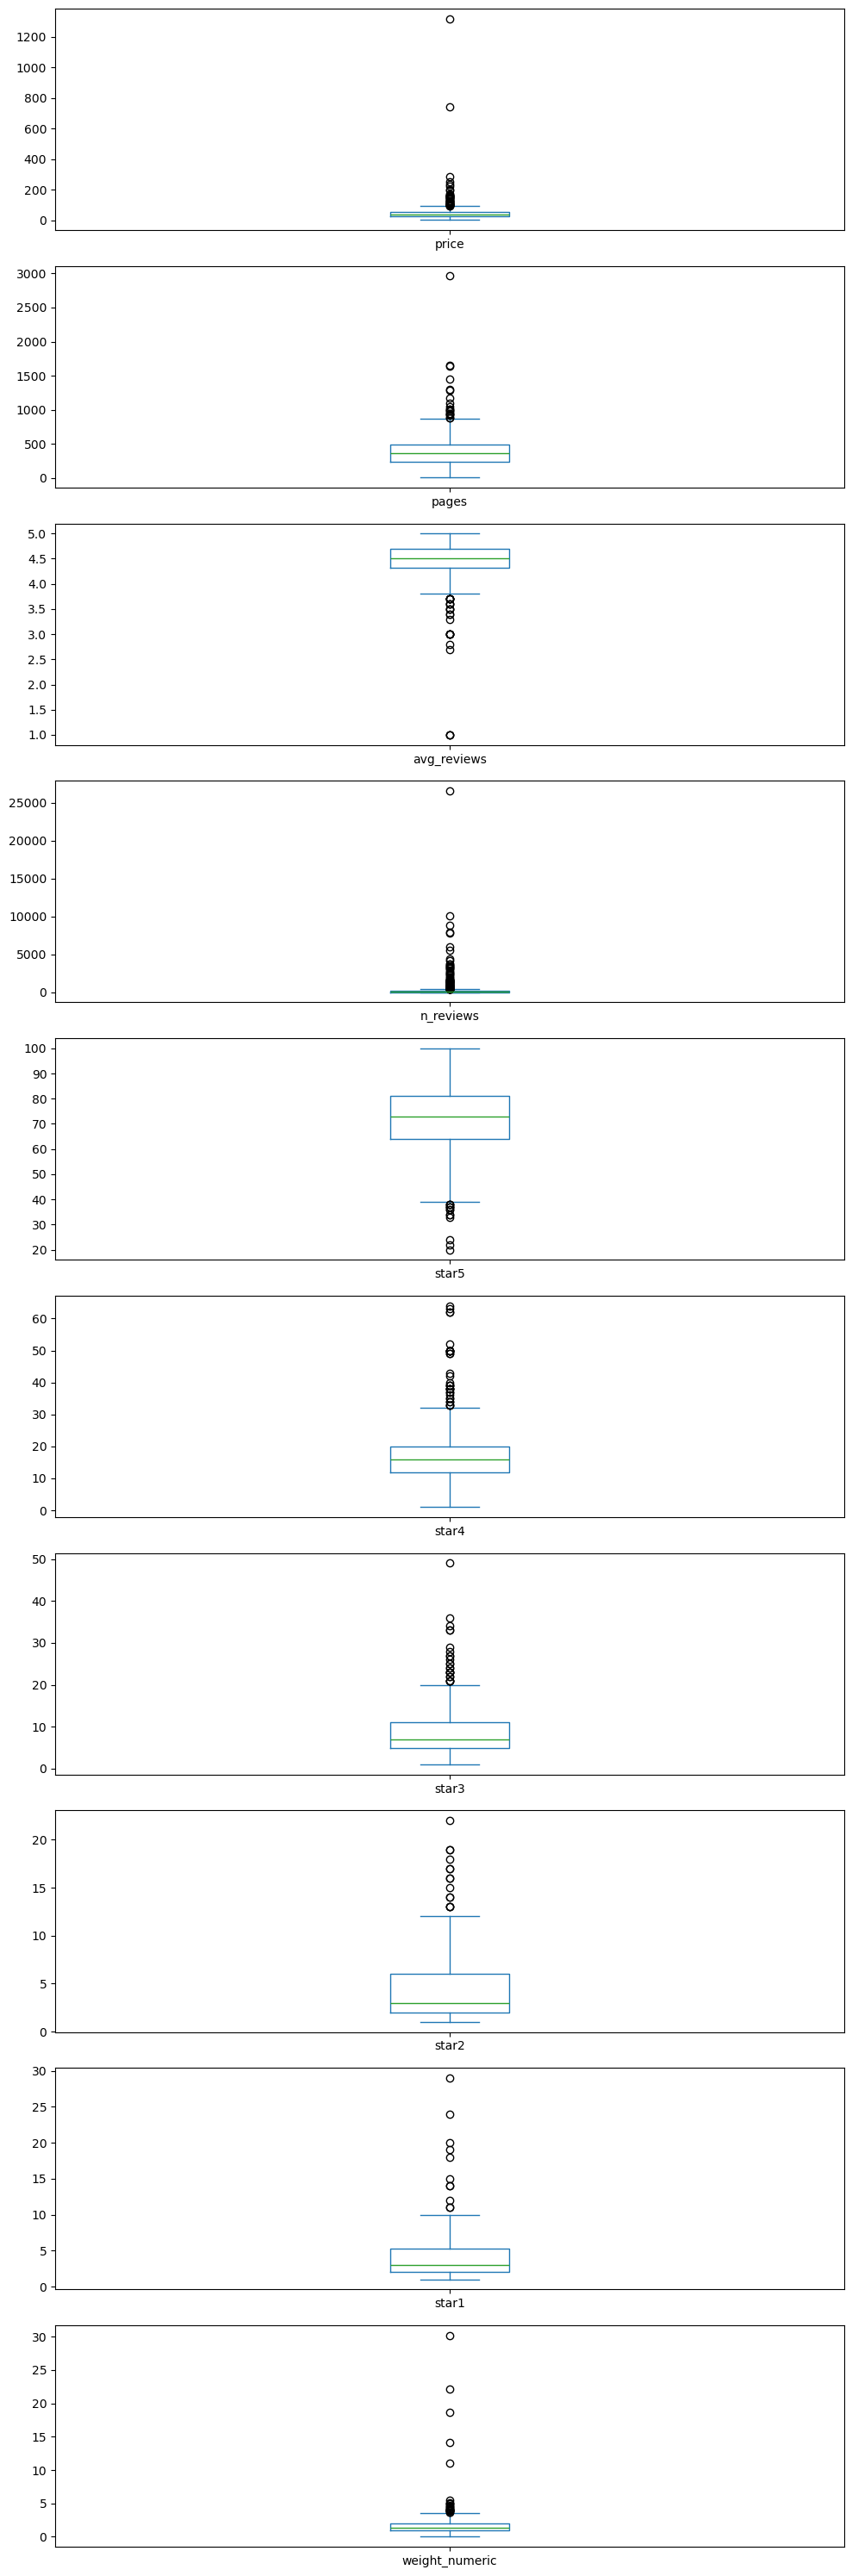

In [12]:
num_df.plot(kind='box', subplots=True, layout=(len(num_df.columns), 1),
            figsize=(10, 3 * len(num_df.columns)), sharex=False)
plt.tight_layout()
plt.show()


**What are the minimum and maximum values?**
- `price` (0.99 → 1318.74).
- `pages` (6 → 2962).
- `avg_reviews` (1.0 → 5.0).
- `n_reviews` (1 → 26,560).
- `star5, star4, star3, star2, star1` (%): All these are percentages from 1% to ~100%.
    - Max `star4` = 64%
    - Max `star3` = 49%
    - Max `star1` = 29%
- `weight_numeric` (0.035 → 30.2).

**Are min/max values reasonable, or do they indicate errors?**
- `price`:
    - Min around $1 is reasonable.
    - Max ~$1300 could be: A genuine academic textbook./ A collector edition./ Possible data extraction error if price strings were parsed incorrectly.
- `pages`:
    - Min = 6 pages → suspicious (probably a pamphlet, product, or data error).
    - Max = 2962 → extremely high but possible (encyclopedia volumes, technical standards).
- `avg_reviews`:
    - Perfectly resonable.
- `n_reviews`:
    - Perfectly resonable.
- `star5, star4, star3, star2, star1` (%):
    - Perfectly resonable.
- `weight_numeric`:
    - Min (0.035 lbs / ~16 grams) — extremely light (possibly eBook or error). 
    - Max = 30 lbs — very suspicious. 

**Are outliers genuine extreme values or data entry errors?**
| Column         | Outliers | Likely Real or Error?                                   |
| -------------- | -------- | ------------------------------------------------------- |
| price          | Moderate | Mostly real, check top values                           |
| pages          | Few      | Mixed: some errors (6 pages), some real (encyclopedias) |
| avg_reviews    | Few      | All real (bounded 1–5 scale)                            |
| n_reviews      | Many     | All real (viral books)                                  |
| star5–star1    | Some     | All real (natural rating variation)                     |
| weight_numeric | Many     | Many are parsing errors                                 |

#### **c. Data Quality**

In [13]:
missing_percentage = num_df.isna().mean() * 100
negative_percentage = (num_df < 0).mean() * 100
zero_percentage = (num_df == 0).mean() * 100

# Common placeholder suspects: -1, 0, 999, 9999
placeholder_values = [-1, 999, 9999]
placeholder_df = pd.DataFrame({
    f"{val}_percentage": (num_df == val).mean() * 100
    for val in placeholder_values
})

# Combine all results
quality_report = pd.concat(
    [missing_percentage.rename("missing_percentage"),
     negative_percentage.rename("negative_percentage"),
     zero_percentage.rename("zero_percentage"),
     placeholder_df],
    axis=1
)

print(quality_report)

                missing_percentage  negative_percentage  zero_percentage  \
price                    13.012048                  0.0              0.0   
pages                    11.325301                  0.0              0.0   
avg_reviews              15.421687                  0.0              0.0   
n_reviews                15.421687                  0.0              0.0   
star5                    15.421687                  0.0              0.0   
star4                    23.493976                  0.0              0.0   
star3                    33.253012                  0.0              0.0   
star2                    45.662651                  0.0              0.0   
star1                    60.481928                  0.0              0.0   
weight_numeric           21.686747                  0.0              0.0   

                -1_percentage  999_percentage  9999_percentage  
price                     0.0             0.0              0.0  
pages                     0.0    

**What percentage of values are missing?**
| Feature        | Missing %     | Interpretation                                                                                                      |
| -------------- | ------------- | ------------------------------------------------------------------------------------------------------------------- |
| price          | **13.0%**     | Moderate missingness, common for scraped e-commerce data if price is not available or varies (used/new).            |
| pages          | **11.3%**     | Normal for books without preview page info.                                                                         |
| avg_reviews    | **15.4%**     | Missing when the book has **no rating yet**.                                                                        |
| n_reviews      | **15.4%**     | Same reason as above.                                                                                               |
| star5 → star1  | **15% → 60%** | Missing increases because many books **don’t show detailed rating percentage breakdown**, especially unrated items. |
| weight_numeric | **21.7%**     | High missingness, weight often not provided by sellers.                                                             |

**Are there any impossible values? (e.g., negative ages, prices = 0)**
- negative_percentage = 0% for all columns. 
- zero_percentage = 0% for all columns. 

**Are there placeholder values? (e.g., 999, -1, 0 used to indicate missing)**
- -1_percentage = 0%
- 999_percentage = 0%
- 9999_percentage = 0%
- No typical placeholder values used by websites or extraction scripts.

### **2.3 Categorical Columns Analysis**
#### **a. Value Distribution**

In [14]:
cat_df = df_clean.select_dtypes(include=['object', 'category'])
cat_df.head()

,title,author,price (including used books),dimensions,weight,language,publisher,ISBN_13,link,complete_link
0,Data Analysis Using R (Low Priced Edition): A ...,[ Dr Dhaval Maheta],6.75,8.5 x 1.01 x 11 inches,2.53 pounds,English,"Notion Press Media Pvt Ltd (November 22, 2021)",978-1685549596,/Data-Analysis-Using-Low-Priced/dp/1685549594/...,https://www.amazon.com/Data-Analysis-Using-Low...
1,Head First Data Analysis: A learner's guide to...,NaN,21.49 - 33.72,8 x 0.98 x 9.25 inches,1.96 pounds,English,"O'Reilly Media; 1st edition (August 18, 2009)",978-0596153939,/Head-First-Data-Analysis-statistics/dp/059615...,https://www.amazon.com/Head-First-Data-Analysi...
2,Guerrilla Data Analysis Using Microsoft Excel:...,"[ Oz du Soleil, and , Bill Jelen]",32.07,8.25 x 0.6 x 10.75 inches,1.4 pounds,English,"Holy Macro! Books; Third edition (August 1, 2022)",978-1615470747,/Guerrilla-Analysis-Using-Microsoft-Excel/dp/1...,https://www.amazon.com/Guerrilla-Analysis-Usin...
3,Python for Data Analysis: Data Wrangling with ...,[ William McKinney],53.99,7 x 1.11 x 9.19 inches,1.47 pounds,English,"O'Reilly Media; 2nd edition (November 14, 2017)",978-1491957660,/Python-Data-Analysis-Wrangling-IPython/dp/149...,https://www.amazon.com/Python-Data-Analysis-Wr...
4,Excel Data Analysis For Dummies (For Dummies (...,[ Paul McFedries],24.49,7.38 x 0.83 x 9.25 inches,1.3 pounds,English,"For Dummies; 5th edition (February 3, 2022)",978-1119844426,/Excel-Data-Analysis-Dummies-Computer/dp/11198...,https://www.amazon.com/Excel-Data-Analysis-Dum...


In [15]:
unique_counts = cat_df.nunique().sort_values(ascending=False)
print("Unique Values per Categorical Column:")
print(unique_counts)

Unique Values per Categorical Column:
title                           830
link                            830
complete_link                   830
publisher                       694
author                          605
dimensions                      540
price (including used books)    523
ISBN_13                         503
weight                          273
language                         12
dtype: int64


In [16]:
top10_title = cat_df['title'].value_counts().head(10)

print("Top 10 Titles:\n")
for i, (title, count) in enumerate(top10_title.items(), start=1):
    print(f"{i}. {title} — {count}")

Top 10 Titles:

1. Data Analysis Using R (Low Priced Edition): A Primer for Data Scientist — 1
2. Classic Computer Science Problems in Python — 1
3. Learn Quantum Computing with Python and IBM Quantum Experience: A hands-on introduction to quantum computing and writing your own quantum programs with Python — 1
4. Machine Learning With Python For Beginners: A Step-By-Step Guide with Hands-On Projects (Learn Coding Fast with Hands-On Project Book 7) — 1
5. Hands-On Gradient Boosting with XGBoost and scikit-learn: Perform accessible machine learning and extreme gradient boosting with Python — 1
6. Python Natural Language Processing Cookbook: Over 50 recipes to understand, analyze, and generate text for implementing language processing tasks — 1
7. Python Concurrency with asyncio — 1
8. Learn Coding Basics for Kids, Young Adults and People Who Are Young at Heart, With Python: Python Computer Programming Made Easy! — 1
9. Modeling and Simulation in Python — 1
10. Learn Python Fast For Absol

In [17]:
top10_publisher = cat_df['publisher'].value_counts().head(10)

print("Top 10 Publishers:\n")
for i, (title, count) in enumerate(top10_publisher.items(), start=1):
    print(f"{i}. {title} — {count}")

Top 10 Publishers:

1. Packt Publishing (April 29, 2022) — 3
2. Packt Publishing (October 31, 2022) — 3
3. Packt Publishing (January 21, 2022) — 3
4. O'Reilly Media; 1st edition (April 17, 2018) — 2
5. Chapman and Hall/CRC; 1st edition (May 10, 2023) — 2
6. O'Reilly Media; 1st edition (December 20, 2022) — 2
7. Packt Publishing - ebooks Account (January 10, 2023) — 2
8. Packt Publishing (June 30, 2022) — 2
9. Dover Publications; Third edition (September 14, 2011) — 2
10. Manning (January 10, 2023) — 2


In [18]:
top10_author = cat_df['author'].value_counts().head(10)

print("Top 10 Authors:\n")
for i, (title, count) in enumerate(top10_author.items(), start=1):
    print(f"{i}. {title} — {count}")

Top 10 Authors:

1. [ Al Sweigart] — 8
2. [ Eric Matthes] — 4
3. [ Inc. BarCharts] — 3
4. [ Chad Knowles] — 3
5. [ Leonard J. Ledger] — 3
6. [ Lee Vaughan] — 3
7. [ Allen B. Downey] — 3
8. [ Alan Agresti] — 3
9. [ Yves Hilpisch] — 3
10. [ Paul A. Zandbergen] — 3


In [19]:
top10_dimensions = cat_df['dimensions'].value_counts().head(10)

print("Top 10 Dimensions:\n")
for i, (title, count) in enumerate(top10_dimensions.items(), start=1):
    print(f"{i}. {title} — {count}")

Top 10 Dimensions:

1. 7 x 0.75 x 9 inches — 6
2. 7.5 x 0.75 x 9.25 inches — 5
3. 7.5 x 0.87 x 9.25 inches — 4
4. 7 x 1 x 9.25 inches — 4
5. 7.5 x 0.82 x 9.25 inches — 4
6. 7.5 x 1.25 x 9.25 inches — 4
7. 7.5 x 0.65 x 9.25 inches — 3
8. 8 x 0.75 x 10 inches — 3
9. 7.25 x 1 x 9.25 inches — 3
10. 8.5 x 11 x 0.06 inches — 3


In [21]:
top10_language = cat_df['language'].value_counts().head(10)

print("Top 10 Language:\n")
for i, (title, count) in enumerate(top10_language.items(), start=1):
    print(f"{i}. {title} — {count}")

Top 10 Language:

1. English — 745
2. Spanish — 4
3. Unqualified, Japanese (Dolby Digital 2.0 Mono), English (Dolby Digital 5.1), English (Dolby Digital 2.0 Mono) — 1
4. you will discover all you need  — 1
5. • How to make better business decisions using  — 1
6. Concepts are presented in a "to-the-point" style to cater to the busy individual. With this book, you can learn Python in just one day and start coding immediately.  — 1
7. standard library — 1
8. This Python programming guide assumes certain level of programming knowledge. It is not a beginner textbook. — 1
9. Scroll to the top of the page and click the  — 1
10. English (Dolby Digital 2.0 Mono) — 1


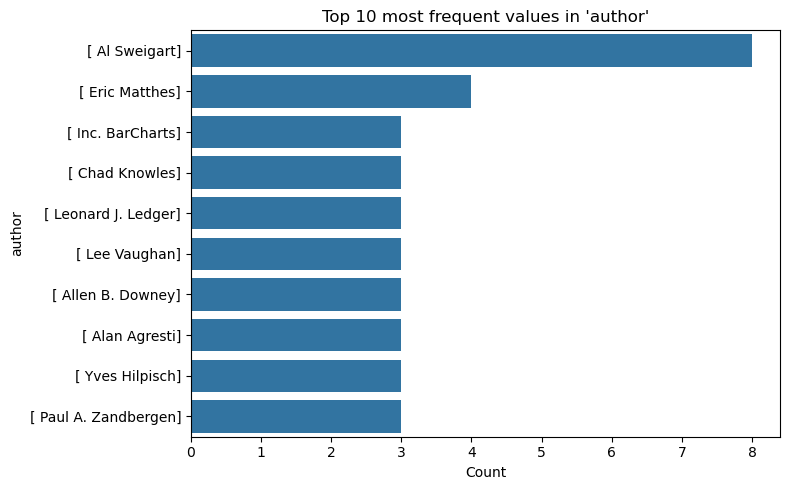

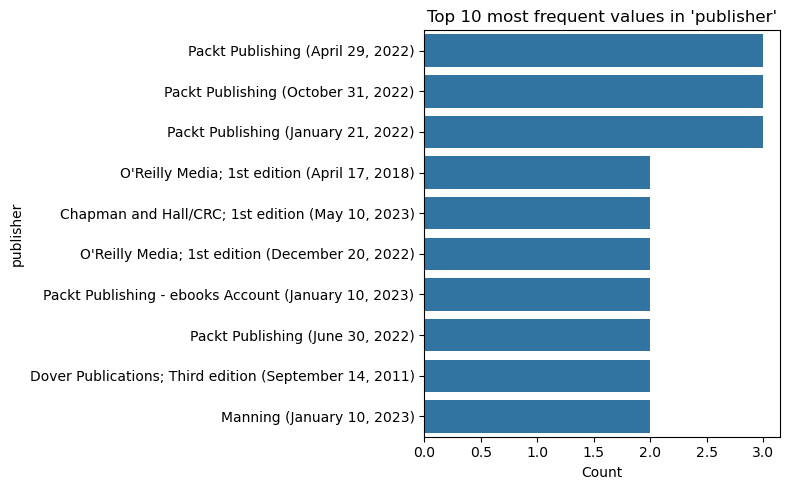

In [22]:
def plot_top_categories(df, col, top_n=10):
    top_vals = df[col].value_counts().head(top_n)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=top_vals.values, y=top_vals.index)
    plt.title(f"Top {top_n} most frequent values in '{col}'")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# plot_top_categories(df_clean, "title")
plot_top_categories(df_clean, "author")
plot_top_categories(df_clean, "publisher")
# plot_top_categories(df_clean, "dimensions")
# plot_top_categories(df_clean, "weight")
# plot_top_categories(df_clean, "language")

**How many unique/distinct values are there?**
| Column                           | Unique Values | 
| -------------------------------- | ------------- | 
| **title**                        | 830           | 
| **link**                         | 830           | 
| **complete_link**                | 830           | 
| **publisher**                    | 694           | 
| **author**                       | 605           | 
| **dimensions**                   | 540           | 
| **price (including used books)** | 523           | 
| **ISBN_13**                      | 503           | 
| **language**                     | 12            | 

**Is the distribution balanced or highly imbalanced?**
- Most columns are highly imbalanced, meaning:
    - They contain mostly unique values.
    - They cannot be meaningfully summarized with frequency counts except for identifying the top few repeated publishers/authors.
    - They indicate a dataset where each row is a distinct book with unique metadata.


#### **b. Data Quality**

In [23]:
cat_missing_percentage = cat_df.isna().mean().sort_values(ascending=False) * 100
print("Missing Percentage per Categorical Column:")
print(cat_missing_percentage)

def normalize_text(x):
    if pd.isna(x):
        return x
    x = x.lower().strip()
    x = re.sub(r'[^a-z0-9 ]+', '', x)      # remove punctuation
    return x

inconsistency_report = {}

for col in cat_df:
    original = df_clean[col].dropna().unique()
    normalized = pd.Series(df_clean[col].dropna().apply(normalize_text)).unique()
    
    if len(original) != len(normalized):
        inconsistency_report[col] = {
            "original_unique": len(original),
            "normalized_unique": len(normalized)
        }

print("\nColumns with inconsistent categories:")
print(inconsistency_report)

Missing Percentage per Categorical Column:
dimensions                      22.409639
weight                          21.566265
author                          20.843373
ISBN_13                         19.879518
publisher                       13.975904
price (including used books)    13.012048
language                         8.554217
title                            0.000000
link                             0.000000
complete_link                    0.000000
dtype: float64

Columns with inconsistent categories:
{'author': {'original_unique': 605, 'normalized_unique': 603}, 'price (including used books)': {'original_unique': 523, 'normalized_unique': 522}, 'weight': {'original_unique': 273, 'normalized_unique': 270}, 'ISBN_13': {'original_unique': 503, 'normalized_unique': 498}}


In [24]:
def is_abnormal(x):
    if pd.isna(x): 
        return False
    if len(x) > 60: 
        return True
    if re.search(r'[.!?]', x): 
        return True
    return False

unexpected_vals = {}

for col in cat_df:

    # Apply is_abnormal on the entire column (keeps index aligned)
    bad = df_clean[col].apply(is_abnormal).fillna(False)

    # Use the aligned boolean mask safely
    abnormal_rows = df_clean.loc[bad, col].unique()

    if len(abnormal_rows) > 0:
        unexpected_vals[col] = abnormal_rows[:10]  # preview only


print("Abnormal or unexpected values found:")
for col, vals in unexpected_vals.items():
    print(f"{col}:")
    # Print one example for visulization
    for v in vals[:1]:  
        print(f" - {v}")


Abnormal or unexpected values found:
title:
 - Data Analysis Using R (Low Priced Edition): A Primer for Data Scientist
author:
 - [ Matthew B. Miles, A. Michael Huberman, et al.]
price (including used books):
 - 6.75
dimensions:
 - 8.5 x 1.01 x 11 inches
weight:
 - 2.53 pounds
language:
 - Unqualified, Japanese (Dolby Digital 2.0 Mono), English (Dolby Digital 5.1), English (Dolby Digital 2.0 Mono)
publisher:
 - Holy Macro! Books; Third edition (August 1, 2022)
ISBN_13:
 - $13.99 
link:
 - /Data-Analysis-Using-Low-Priced/dp/1685549594/ref=sr_1_16?keywords=data+analysis&qid=1671164640&sr=8-16
complete_link:
 - https://www.amazon.com/Data-Analysis-Using-Low-Priced/dp/1685549594/ref=sr_1_16?keywords=data+analysis&qid=1671164640&sr=8-16


In [25]:
rare_categories = {}

for col in cat_df:
    freq = df_clean[col].value_counts()
    rares = freq[freq <= 2]
    if len(rares) > 0:
        rare_categories[col] = rares

print("Rare categories (freq ≤ 2):")
for col, vals in rare_categories.items():
    print(f"\n{col}:")
    print(vals)


Rare categories (freq ≤ 2):

title:
title
Data Analysis Using R (Low Priced Edition): A Primer for Data Scientist                                                                                           1
Classic Computer Science Problems in Python                                                                                                                       1
Learn Quantum Computing with Python and IBM Quantum Experience: A hands-on introduction to quantum computing and writing your own quantum programs with Python    1
Machine Learning With Python For Beginners: A Step-By-Step Guide with Hands-On Projects (Learn Coding Fast with Hands-On Project Book 7)                          1
Hands-On Gradient Boosting with XGBoost and scikit-learn: Perform accessible machine learning and extreme gradient boosting with Python                           1
                                                                                                                                          

**What percentage of values are missing?**
| Column                           | Missing % | Interpretation                                                                |
| -------------------------------- | --------- | ----------------------------------------------------------------------------- |
| **dimensions**                   | 22.41%    | Very high, many products missing dimension details.                           |
| **weight**                       | 21.57%    | Very high, consistent with Amazon listings missing physical specs.            |
| **author**                       | 20.84%    | Likely missing when sellers do not enter author field.                        |
| **ISBN_13**                      | 19.88%    | Concerning: ISBN should uniquely identify books. Many sellers leave it empty. |
| **publisher**                    | 13.98%    | Moderate; publishing info often missing in self-published books.              |
| **price (used)**                 | 13.01%    | Missing when “used” option not available.                                     |
| **language**                     | 8.55%     | Low, but some entries clearly wrong (not languages).                          |
| **title / link / complete_link** | 0%        | Perfect, expected.                                                            |

**Are there inconsistencies in categories?**
| Column         | Original | Normalized | Difference | Meaning                                                            |
| -------------- | -------- | ---------- | ---------- | ------------------------------------------------------------------ |
| **author**     | 605      | 603        | 2          | Small inconsistencies (extra spaces, punctuation).                 |
| **price_used** | 523      | 522        | 1          | Minor formatting inconsistency.                                    |
| **weight**     | 273      | 270        | 3          | Some formatting variations (e.g., “pounds” vs “lb”, extra spaces). |
| **ISBN_13**    | 503      | 498        | 5          | Some invalid strings or formatting issues.                         |

**Are there unexpected or abnormal values?**
- `author`: "[ Matthew B. Miles, A. Michael Huberman, et al.]"
    - Indicates scraping extracted text inside brackets.
    - Should be cleaned into a list or multiple authors.
- `price`: some prices have ranges: "71.18 - 193.32"
    - Unexpected: Amazon provides price ranges only when multiple sellers list variations.
    - Not numeric, must be parsed or discarded.
- `language`: Contains completely wrong entries such as “you will discover all you need”
    - Scraping errors.
    - Wrong text extracted from product description, not the language field.
- `ISBN_13`: Abnormal value:
    - "$13.99" → a price, incorrectly placed in ISBN field.
    - "69" or "59" (two-digit values) → invalid ISBNs.

**Are there categories with very few observations? Should they be grouped?**
- There are categories with very few observations but in this scenario, grouping them is not very important.

### **2.4 Missing Data Analysis**

                              Count  Percentage
star1                           502   60.481928
star2                           379   45.662651
star3                           276   33.253012
star4                           195   23.493976
dimensions                      186   22.409639
weight_numeric                  180   21.686747
weight                          179   21.566265
author                          173   20.843373
ISBN_13                         165   19.879518
star5                           128   15.421687
n_reviews                       128   15.421687
avg_reviews                     128   15.421687
publisher                       116   13.975904
price                           108   13.012048
price (including used books)    108   13.012048
pages                            94   11.325301
language                         71    8.554217


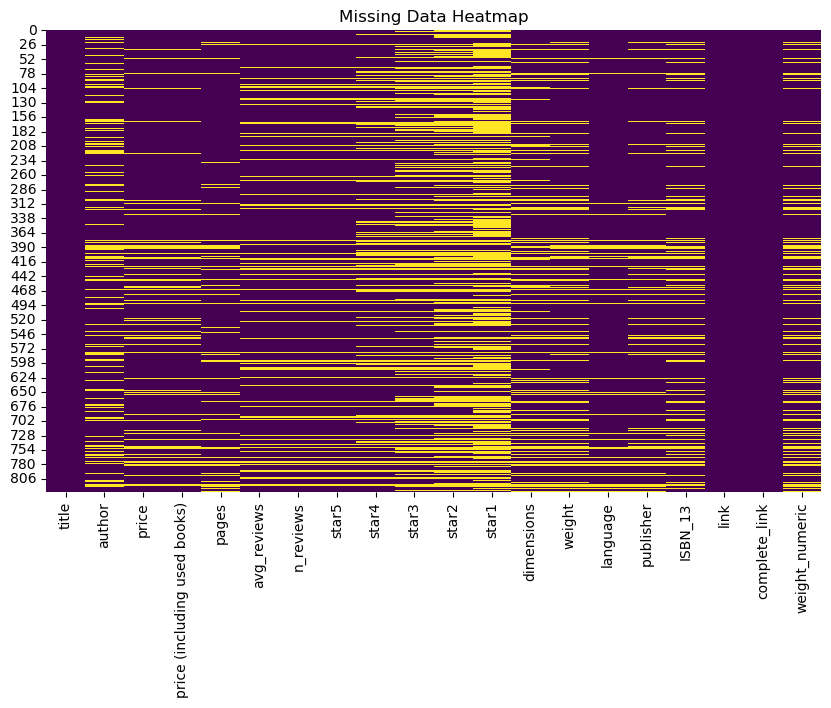

In [26]:
# Missing Data Summary
missing = df_clean.isnull().sum()
missing_pct = (missing / len(df_clean)) * 100
missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Count'] > 0].sort_values(by='Percentage', ascending=False))

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_clean.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

#### **a. Overall Assessment:**
**Are missing values random, or is there a pattern?**
- The missingness is not random. Rows missing `n_reviews` are also missing `avg_reviews` and `star5` (since you can't have a rating without reviews). 

**Do certain rows or groups have more missing values?**
- `star1` (60%) is missing more often than `star5` (15%), implying books with few reviews might not have any 1-star ratings yet.

#### **b. Per Column Strategy:**
**Why might values be missing? (random, not applicable, data collection issue)**
- Reviews/Stars: Missing likely means 0 reviews. 
- Author/Publisher: Missing is likely data collection failure. 
- Price: ~13% missing. 

**What is your plan to handle them? (remove, impute, keep as separate category)**
- Impute `n_reviews` = 0 and `avg_reviews` = global average (or median).
- Fill `Author/Publisher` with "Unknown".
- Since `price` is the target variable for many questions, might drop these rows for price-specific analysis.


### **2.5 Relationships & Correlations**

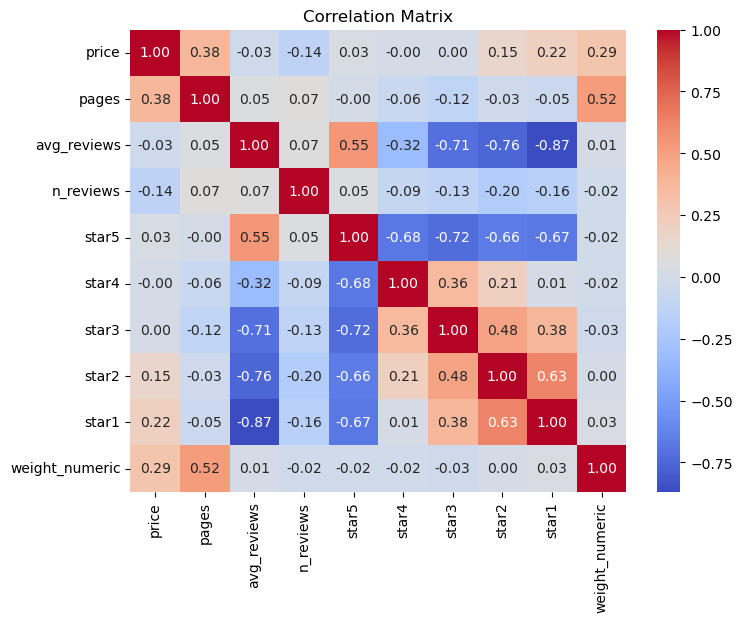

In [27]:
# Correlation Matrix
corr_matrix = num_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

#### **a. Preliminary Patterns**
**Are there any surprising relationships?**
- `Price` vs `Reviews` (-0.14): No strong correlation. Expensive books are not necessarily more popular.
- `Reviews` vs `Rating` (0.07): Popularity (`n_reviews`) does not correlate with quality (`avg_reviews`).
- `Pages` vs `Weight` (-0.24): It is unexpected because more pages → heavier book.

#### **b. Cross-tabulations**


Frequency Table: Price Tier vs Rating Tier
rating_tier         Lower (<4.3)  Average (4.3-4.7)  High (>4.7)
price_tier                                                      
Budget (<$25)                 47                106           45
Standard ($25-$50)            71                166           48
Premium (>$50)                35                 87           32


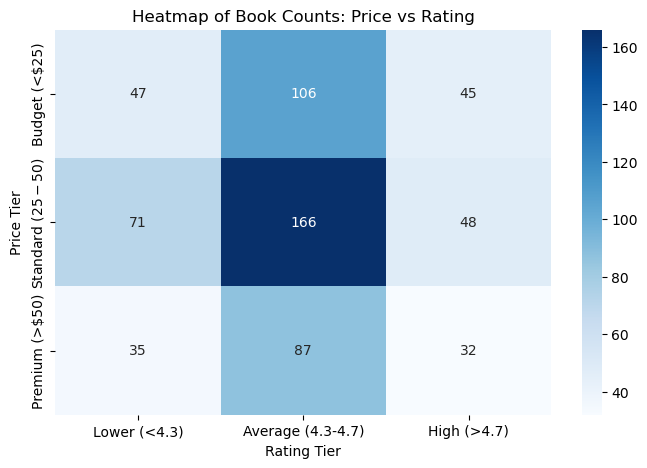

In [28]:
# Create categorical tiers
df_clean['price_tier'] = pd.cut(df_clean['price'],
                                bins=[0, 25, 50, 2000],
                                labels=['Budget (<$25)', 'Standard ($25-$50)', 'Premium (>$50)'])

df_clean['rating_tier'] = pd.cut(df_clean['avg_reviews'],
                                 bins=[0, 4.3, 4.7, 5.0],
                                 labels=['Lower (<4.3)', 'Average (4.3-4.7)', 'High (>4.7)'])

# Cross-tabulation frequency table
ct_price_rating = pd.crosstab(df_clean['price_tier'], df_clean['rating_tier'])

print("Frequency Table: Price Tier vs Rating Tier")
print(ct_price_rating)

# Visualize with a Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(ct_price_rating, annot=True, fmt='d', cmap='Blues')
plt.title('Heatmap of Book Counts: Price vs Rating')
plt.ylabel('Price Tier')
plt.xlabel('Rating Tier')
plt.show()

In [29]:
# 1. Clean Publisher Names (Remove dates inside parenthesis)
def clean_publisher(x):
    if pd.isna(x): return "Unknown"
    return x.split('(')[0].strip()

df_clean['publisher_clean'] = df_clean['publisher'].apply(clean_publisher)

# 2. Identify Top 5 Publishers
top_pubs = df_clean['publisher_clean'].value_counts().head(5).index

# 3. Grouped Summary Statistics
grouped_stats = df_clean[df_clean['publisher_clean'].isin(top_pubs)].groupby('publisher_clean')[['price', 'avg_reviews']].agg(['mean', 'median', 'count'])

print("Summary Stats for Top 5 Publishers:")
print(grouped_stats)

Summary Stats for Top 5 Publishers:
                                 price               avg_reviews             
                                  mean  median count        mean median count
publisher_clean                                                              
Independently published      22.714074  19.240    81    4.429577   4.50    71
O'Reilly Media; 1st edition  43.561373  43.490    51    4.431915   4.50    47
Packt Publishing             44.155946  44.990    74    4.466197   4.40    71
Unknown                      26.053500  20.060    20    4.351351   4.45    74
Wiley; 1st edition           31.921250  25.745    24    4.425000   4.50    24


**Categorical × Categorical: Price Tier vs. Rating Quality**
- The majority of books fall into the "Standard" price range ($25-$50) with "Average" ratings (4.3-4.7). Interestingly, "Premium" books (>$50) do not show a higher proportion of "High" ratings compared to "Budget" books, suggesting that paying more does not guarantee a better reader experience. 

**Numerical × Categorical: Publisher Performance**
- "O'Reilly Media" and "Packt Publishing" have significantly higher average prices (~$44) compared to "Independently published" books (~$23). 
- Despite the price difference, the average ratings are nearly identical across all publishers (~4.4), reinforcing the idea that self-published budget books can compete with major publishers in terms of reader satisfaction.

### **2.6 Initial Observations & Insights**
#### **a. Summary**
**What are 3-5 key observations from your exploration?**
- Book prices vary a lot
    - Most books cost between $20 and $50.
    - A small number of books are extremely expensive (up to $1300), which makes the price distribution very skewed.
- Ratings are generally very high
    - Most books have ratings around 4.5 stars.
    - Very few books are rated below 4 stars.
    - Expensive books are not rated better than cheaper ones.
- Most books are in English
    - The majority of entries list English as the language.
    - However, some language values are clearly wrong and contain random text instead of a real language.
    
**What data quality issues did you identify?**
- Many missing values
    - Important information is often missing, such as:
        - Dimensions (22%)
        - Weight (22%)
        - Author (21%)
        - ISBN (20%)
        - Publisher and used price (around 13–14%)
        - Star rating breakdown (15–60%)
- Invalid or incorrect data
    - ISBN fields sometimes contain prices or random numbers.
    - Language field includes sentences or metadata instead of languages.
    - Prices sometimes appear as ranges instead of single numbers.
    - Author names are sometimes stored as messy lists inside brackets.
- Inconsistent formatting
    - Weight is recorded in different units (pounds and ounces).
    - Dimensions are written in different formats.
    - Publisher names often include extra information like edition or date.
    - Author names are not stored consistently.
- Extreme values
    - Some values are unusually large, such as:
    - Very high prices
    - Extremely long books
    - Very heavy books
- These may be real but could also be data errors.

**What preprocessing steps will be necessary?**
- Clean text fields
    - Fix author names, publisher names, ISBNs, and language values.
    - Remove brackets and extract only valid information.
- Convert fields into numeric format
    - Split dimensions into height, width, and depth.
    - Convert all weights into grams.
    - Convert price ranges into a single numeric value.
- Handle missing data
    - Fill missing values using common methods (median or most frequent value).
- Deal with outliers
    - Cap extreme values or investigate whether they are errors.

**What interesting patterns emerged that could lead to research questions?**
- Book price shows large variation, even among books with similar ratings.
- Longer books do not always receive better ratings.
- Highly rated and poorly rated books can have very different value-for-money profiles.
- Price patterns suggest predictability from available features.

#### **b. Red Flags**
**List any serious data quality concerns**
- Language column is heavily corrupted (contains random sentences and DVD audio metadata).
- ISBN field includes prices and invalid strings.
- High missingness in important structural attributes (dimensions, weight, ISBN).
- Inconsistent formatting in authors, publishers, weights, and price ranges.
- Star rating breakdown has extremely high missingness (up to 60%).

**Note any limitations that might affect your analysis**
- Major concerns:
    - Language and ISBN fields are heavily corrupted.
    - Many important attributes are missing.
    - Rating breakdown data is incomplete.
- Limitations of the dataset:
    - Many fields (titles, authors, publishers) are too unique for strong categorical analysis.
    - Ratings are clustered closely together, making differences hard to detect.
    - Several numeric fields contain extreme values that may affect results.